## Complementarity & Accessibilty

### 1.  Imports & Declarations

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from haversine import haversine as hs
import requests
%matplotlib inline
# from pydantic_settings import BaseSettings
from ydata_profiling import ProfileReport

import sys
sys.path.append('../utils/')
from functions import get_zone_info
# from functions import haversine_distance as hs

In [6]:
##############################################################################################################
# GREEN MOBILITY
##############################################################################################################

# Initialize dataframe
file_path = "../data/processed/gm_raw.csv"
gm_source = pd.read_csv(file_path)

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

# Add columns if necessary

#################################################################################################################
# DRIVE NOW
#################################################################################################################

# 1. Initialize dataframe
file_path = "../data/raw/DriveNow/DTU - data til case_LTMZones1.csv"
sn_source = pd.read_csv(file_path, sep=";")

# 2. Rename columns if necessary
sn_source.rename(columns= {
                            "Latitude (Start)": "LatitudeStart", 
                            "Longitude (Start)": "LongitudeStart", 
                            'Latitude (Slut)': "LatitudeEnd", 
                            'Longitude (Slut)':'LongitudeEnd',
                            'Reservationstidspunkt': "ReservationTime",
                            'Start tidspunkt': "StartTime",
                            'Slut tidspunkt': "EndTime",
                            'Alder': "Age",
                            'Køn': "Gender",
                            'Batteristatus (start)': "BatteryStart",
                            'Batteristatus (slut)':"BatteryEnd",
                            'Km kørt': "KmDriven"
                            }, inplace=True)

# 3. Drop columns if necessary
sn_source.drop(columns=['TurID'],inplace=True)

# 4. Convert to appropriate data types
# Convert to Numeric the following columns:
target_ls = [
    'KmDriven',
    'BatteryStart',
    'BatteryEnd',
    'LatitudeEnd',
    'LatitudeStart',
    'LongitudeEnd',
    'LongitudeStart'
]
for col in target_ls:
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


# 5. Auxiliary columns
sn_source['TripDurationHours'] = (sn_source['EndTime'] - sn_source['StartTime']).dt.total_seconds()/3600
sn_source['TripDurationMinutes'] = sn_source['TripDurationHours']*60  #   trip duration in min
sn_source['AvgSpeed'] = sn_source['KmDriven']/sn_source['TripDurationHours'] #   avg speed

sn_source['Month'] = sn_source['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_source['Weekday'] = sn_source['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_source['StartHour'] = sn_source['StartTime'].dt.hour.astype('category')    #   hour of the day

# 6. Descriptive statistics
sn_source.describe()

# 7. Drop outliers, missing values, etc.

# drop rows with missing values
sn_source.dropna(inplace=True)

# drop rows with BatteryEnd less than BatteryStart
sn_source = sn_source[sn_source['BatteryStart'] <= sn_source['BatteryEnd']]

# replace negative BatteryEnd with 0
sn_source['BatteryEnd'] = sn_source['BatteryEnd'].apply(lambda x: 0 if x < 0 else x)

# drop rows with negative and avg speed > 100 km/h
sn_source = sn_source[(sn_source['AvgSpeed'] > 0) & (sn_source['AvgSpeed'] < 100)]

# 8. Add columns if necessary
# Add haversise distance to the dataframe

# sn_source['HaversineDistance'] = hs((sn_source['LatitudeStart'], sn_source['LongitudeStart']),(sn_source['LatitudeEnd'], sn_source['LongitudeEnd']))


##################################################################################################################
# DONKEY REPUBLIC
##################################################################################################################


# Initialize Donkey Republic dataframe
file_path = ""
donkey_source = ""

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_56910/1177208554.py:25: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sn_source = pd.read_csv(file_path, sep=";")
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_56910/1177208554.py:60: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_56910/1177208554.py:61: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


In [24]:
# ProfileReport(sn_source, title="DriveNow", explorative=True)
def get_osrm_route_distance(start_lat, start_lon, end_lat, end_lon):
    route_service_url = f"http://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}?overview=false"
    response = requests.get(route_service_url)
    # Check if the response was successful
    if response.status_code != 200:
        return None
    routes = response.json().get('routes')
    if routes:
        return routes[0]['distance'] / 1000.0  # convert to km
    

_ = sn_source

print(get_osrm_route_distance(_['LatitudeStart'].iloc[0], _['LongitudeStart'].iloc[0], _['LatitudeEnd'].iloc[0], _['LongitudeEnd'].iloc[0]))



None


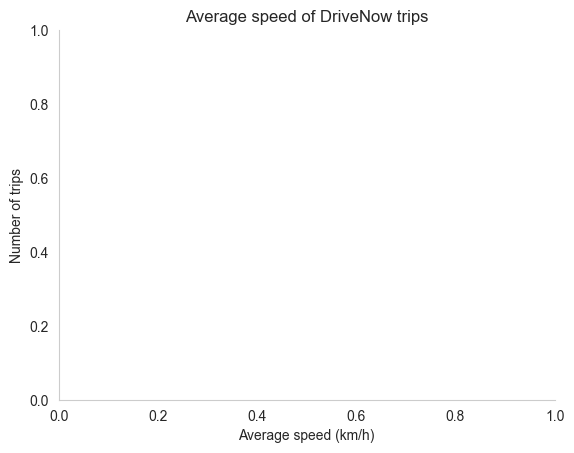

In [7]:
# plot histogram of average speed between 0 and 90 km/h using seaborn 
sns.histplot(data=sn_source[(sn_source['AvgSpeed']>0) & (sn_source['AvgSpeed']<90)], x="AvgSpeed", bins=30, color='blue', kde=True)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')

sns.despine()

# add title and labels
plt.title("Average speed of DriveNow trips")
plt.xlabel("Average speed (km/h)")
plt.ylabel("Number of trips")
plt.grid(False)
# plt.show()

# show median on the plot
plt.axvline(x=sn_source['AvgSpeed'].median(), color='red', linestyle='--', linewidth=1)
plt.show()

In [106]:
sn_source

,BilID,PersonID,LatitudeStart,LongitudeStart,LatitudeEnd,LongitudeEnd,ReservationTime,StartTime,EndTime,Age,...,BatteryEnd,KmDriven,FromZoneID,ToZoneID,TripDurationHours,TripDurationMinutes,AvgSpeed,Month,Weekday,StartHour


### 2.  Trips profiling and statistics

#### 2.1 GreenMobility Dataset

In [4]:
sn_source['AvgSpeed'].median()

nan

/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_88003/1427624344.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)


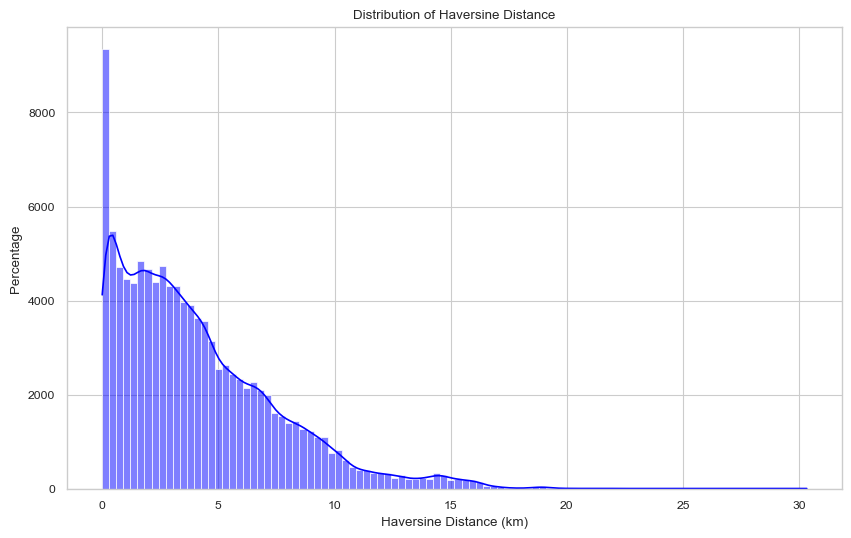

In [ ]:
# distribution of haversine distance visuzaliations
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.set_palette('Blues_r')
sns.despine()
sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)
plt.ylabel('Percentage')
# plt.yticks(np.arange(0, 0.06, 0.01))
# plt.gca().yaxis.set_major_formatter('{:.0f}%'.format)
plt.xlabel('Haversine Distance (km)')
plt.title('Distribution of Haversine Distance')
# plt.savefig('../reports/figures/haversine_distance.png')
plt.show()

In [ ]:
# Generate the profile report
profile = ProfileReport(sn_source, title='Pandas Profiling Report', explorative=True)

# Or to view it in a Jupyter Notebook
profile.to_notebook_iframe()


In [90]:
sn_source[['LatitudeEnd','LatitudeStart','LongitudeEnd','LongitudeStart']]

,LatitudeEnd,LatitudeStart,LongitudeEnd,LongitudeStart
2,"55,775655","55,692382","12,513962","12,583143"
3,"55,706866","55,630274","12,587122","12,648864"
4,"55,677484","55,693602","12,489247","12,53821"
5,"55,630263","55,700745","12,648955","12,473436"
6,"55,692454","55,680014","12,504951","12,507755"
...,...,...,...,...
365424,"55,665031","55,668776","12,516615","12,516638"
365442,"55,656599","55,665624","12,487849","12,483596"
365448,"55,671479","55,676891","12,533911","12,538845"
365464,"55,671468","55,672062","12,534098","12,495884"


## STATISTICAL ANALYSIS : Hypothesis testing